# Data Engineering Challenge 3

In [1]:
from urllib.request import urlopen

import json

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


%matplotlib inline

## Downloading and exploring "Food service establishment inspection" dataset

In [2]:
response = urlopen('https://health.data.ny.gov/api/views/cnih-y5dw/rows.json?accessType=DOWNLOAD')
health = response.read()
data = json.loads(health)

In [3]:
data.keys()

dict_keys(['meta', 'data'])

In [4]:
data['meta'].keys()

dict_keys(['view'])

In [5]:
data['meta']['view'].keys()

dict_keys(['id', 'name', 'assetType', 'attribution', 'attributionLink', 'averageRating', 'category', 'createdAt', 'description', 'displayType', 'downloadCount', 'hideFromCatalog', 'hideFromDataJson', 'newBackend', 'numberOfComments', 'oid', 'provenance', 'publicationAppendEnabled', 'publicationDate', 'publicationGroup', 'publicationStage', 'rowsUpdatedAt', 'rowsUpdatedBy', 'tableId', 'totalTimesRated', 'viewCount', 'viewLastModified', 'viewType', 'approvals', 'columns', 'grants', 'metadata', 'owner', 'query', 'rights', 'tableAuthor', 'tags', 'flags'])

In [6]:
data['meta']['view']['columns']

[{'id': -1,
  'name': 'sid',
  'dataTypeName': 'meta_data',
  'fieldName': ':sid',
  'position': 0,
  'renderTypeName': 'meta_data',
  'format': {},
  'flags': ['hidden']},
 {'id': -1,
  'name': 'id',
  'dataTypeName': 'meta_data',
  'fieldName': ':id',
  'position': 0,
  'renderTypeName': 'meta_data',
  'format': {},
  'flags': ['hidden']},
 {'id': -1,
  'name': 'position',
  'dataTypeName': 'meta_data',
  'fieldName': ':position',
  'position': 0,
  'renderTypeName': 'meta_data',
  'format': {},
  'flags': ['hidden']},
 {'id': -1,
  'name': 'created_at',
  'dataTypeName': 'meta_data',
  'fieldName': ':created_at',
  'position': 0,
  'renderTypeName': 'meta_data',
  'format': {},
  'flags': ['hidden']},
 {'id': -1,
  'name': 'created_meta',
  'dataTypeName': 'meta_data',
  'fieldName': ':created_meta',
  'position': 0,
  'renderTypeName': 'meta_data',
  'format': {},
  'flags': ['hidden']},
 {'id': -1,
  'name': 'updated_at',
  'dataTypeName': 'meta_data',
  'fieldName': ':updated_at'

## Importing data to pandas including flattening and type conversion

In [7]:
from collections import OrderedDict
columns = OrderedDict()
for col in data['meta']['view']['columns']:
    col_name = col['fieldName']
    if 'subColumnTypes' in col:
        for sub_col in col['subColumnTypes']:
            columns['{}.{}'.format(col_name, sub_col)] = 'object'
    else:
        columns[col_name] = col['dataTypeName']
for col in columns:
    print('{:<30} {}'.format(col, columns[col]))

:sid                           meta_data
:id                            meta_data
:position                      meta_data
:created_at                    meta_data
:created_meta                  meta_data
:updated_at                    meta_data
:updated_meta                  meta_data
:meta                          meta_data
facility                       text
address                        text
date                           calendar_date
violations                     text
total_critical_violations      number
total_crit_not_corrected       number
total_noncritical_violations   number
description                    text
local_health_department        text
county                         text
facility_address               text
city                           text
zip_code                       text
nysdoh_gazetteer_1980          text
municipality                   text
operation_name                 text
permit_expiration_date         calendar_date
permitted_d_b_a                text


In [8]:
type_mapping = {'calendar_date': 'datetime64', 'number': 'float64'}
for col in columns:
    columns[col] = type_mapping.get(columns[col], 'object')

In [9]:
for i, row in enumerate(data['data']):
    _ls = []
    for val in row:
        if isinstance(val, list):
            for elem in val:
                _ls.append(elem)
        else:
            _ls.append(val)
    data['data'][i] = _ls

In [10]:
df = pd.json_normalize(data, record_path=['data'])

In [11]:
df.columns = columns.keys()

### Some data cleaning

In [12]:
df = df.replace('3020-12-31T00:00:00', '2020-12-31T00:00:00').replace('3201-03-31T00:00:00', '2013-03-31T00:00:00')

In [13]:
df = df.astype(columns)

In [14]:
df.head()

:sid                                   :id :position  \
0  row-bpau-wjf6_ivu5  00000000-0000-0000-91F5-7AA5BAB33890         0   
1  row-qpem_rva6.tvbw  00000000-0000-0000-5483-810211A4AF14         0   
2  row-3xqu-qu2d.4jfy  00000000-0000-0000-122A-898C6105B8B4         0   
3  row-jhvx_2gww~8cd2  00000000-0000-0000-B8AD-99587B4A3A11         0   
4  row-jq9y.g9at-3u8i  00000000-0000-0000-B69E-5269F56A5E80         0   

  :created_at :created_meta :updated_at :updated_meta :meta  \
0  1607020723          None  1607020740          None   { }   
1  1607020723          None  1607020740          None   { }   
2  1607020723          None  1607020740          None   { }   
3  1607020723          None  1607020740          None   { }   
4  1607020723          None  1607020740          None   { }   

             facility                        address  ...  \
0       DUNKIN DONUTS      1-3-5 PARK STREET,  OWEGO  ...   
1         Tim Hortons       154 Elm Street,  Potsdam  ...   
2      LITTLE GIGGLES       11 QUEEN  STREET,  LYONS  ...   
3    WHAT'S THE SCOOP    20 MATTHEWS STREET,  GOSHEN  ...   
4  LITTLE JAVA COFFEE  3425 WINTON PLACE,  ROCHESTER  ...   

  location1.human_address location1.latitude  location1.longitude  \
0                    None          42.101826           -76.262027   
1                    None          44.669995             -74.9624   
2                    None           43.06576           -76.992244   
3                    None           41.39624           -74.334203   
4                    None           43.09676           -77.578123   

   location1.machine_address  location1.needs_recoding  \
0                       None                     False   
1                       None                     False   
2                       None                     False   
3                       None                     False   
4                       None                     False   

  :@computed_region_43an_4dx5 :@computed_region_9yqb_tdyd  \
0                       450.0                       630.0   
1                      1597.0                      2140.0   
2                       315.0                       631.0   
3                      1504.0                      2134.0   
4                      1682.0                      2093.0   

  :@computed_region_assa_msit :@computed_region_8ire_itmf  \
0                        45.0                         NaN   
1                        40.0                         NaN   
2                        54.0                         NaN   
3                        32.0                         NaN   
4                        56.0                         NaN   

  :@computed_region_5edz_4hdv  
0                       343.0  
1                       918.0  
2                       783.0  
3                        47.0  
4                       785.0  

[5 rows x 43 columns]

### Adding "year" feature and printing the schema

In [15]:
df['year'] = pd.DatetimeIndex(df['date']).year

In [16]:
df.dtypes

:sid                                    object
:id                                     object
:position                               object
:created_at                             object
:created_meta                           object
:updated_at                             object
:updated_meta                           object
:meta                                   object
facility                                object
address                                 object
date                            datetime64[ns]
violations                              object
total_critical_violations              float64
total_crit_not_corrected               float64
total_noncritical_violations           float64
description                             object
local_health_department                 object
county                                  object
facility_address                        object
city                                    object
zip_code                                object
nysdoh_gazett

In [17]:
df.describe()

total_critical_violations  total_crit_not_corrected  \
count               22618.000000              22618.000000   
mean                    0.253957                  0.006146   
std                     0.760805                  0.101748   
min                     0.000000                  0.000000   
25%                     0.000000                  0.000000   
50%                     0.000000                  0.000000   
75%                     0.000000                  0.000000   
max                    15.000000                  4.000000   

       total_noncritical_violations  :@computed_region_43an_4dx5  \
count                  22618.000000                 22707.000000   
mean                       1.993943                   935.254107   
std                        2.892880                   540.955167   
min                        0.000000                     2.000000   
25%                        0.000000                   431.500000   
50%                        1.000000                   978.000000   
75%                        3.000000                  1444.000000   
max                       49.000000                  1791.000000   

       :@computed_region_9yqb_tdyd  :@computed_region_assa_msit  \
count                 22702.000000                 22723.000000   
mean                   1891.887411                    39.218809   
std                     531.004972                    15.041725   
min                     427.000000                     5.000000   
25%                    2035.000000                    32.000000   
50%                    2094.000000                    41.000000   
75%                    2136.000000                    53.000000   
max                    3216.000000                    62.000000   

       :@computed_region_8ire_itmf  :@computed_region_5edz_4hdv          year  
count                  3221.000000                 22713.000000  22734.000000  
mean                     40.849426                   495.361863   2019.374593  
std                      27.929781                   284.939658      1.133812  
min                       1.000000                     2.000000   2006.000000  
25%                      14.000000                   242.000000   2019.000000  
50%                      43.000000                   522.000000   2020.000000  
75%                      56.000000                   767.000000   2020.000000  
max                     100.000000                   935.000000   2020.000000

## Analysis of non-critical violations

### Aggregating non-critical violations by facility and year

In [18]:
sum_by_facility_year = df.groupby(['facility', 'year'], as_index=False).sum()[['year', 'facility', 'total_noncritical_violations']]

### Finding the facility with the highest number of non-critical violations each year

In [19]:
sum_by_facility_year.groupby('year', as_index=False).max()[['year', 'total_noncritical_violations']]

year  total_noncritical_violations
0   2006                           0.0
1   2007                           1.0
2   2008                           5.0
3   2009                           7.0
4   2010                           2.0
5   2011                           1.0
6   2012                           4.0
7   2013                           4.0
8   2014                           8.0
9   2015                          24.0
10  2016                          23.0
11  2017                          15.0
12  2018                          30.0
13  2019                         142.0
14  2020                         177.0

In [20]:
idx = sum_by_facility_year.groupby(['year'])['total_noncritical_violations'].transform(max) == sum_by_facility_year['total_noncritical_violations']

In [21]:
yearly_maxes = sum_by_facility_year[idx].sort_values('year')

In [22]:
yearly_maxes

year                           facility  total_noncritical_violations
15701  2006           SALVATION ARMY (pt & pn)                           0.0
6209   2007        FAMILY LIFE MINISTRIES (pn)                           1.0
5253   2008                      DUNKIN DONUTS                           5.0
5254   2009                      DUNKIN DONUTS                           7.0
5255   2010                      DUNKIN DONUTS                           2.0
3884   2011  COI SED Summer Feeding Program #2                           1.0
2977   2012          CARLE PL SD - HIGH SCHOOL                           4.0
1787   2013        BLUEBIRD HOMEMADE ICE CREAM                           4.0
3433   2013          CHERRY TREE FROZEN YOGURT                           4.0
9331   2014                  JT'S EATERY & PUB                           8.0
5258   2015                      DUNKIN DONUTS                          24.0
13616  2016                  PARK PLACE BAGELS                          23.0
7273   2017           GLENS FALLS CIVIC CENTER                          15.0
12648  2018           NICOLETTA'S ITALIAN CAFE                          30.0
5262   2019                      DUNKIN DONUTS                         142.0
5263   2020                      DUNKIN DONUTS                         177.0

From the yearly maxes dataframe it's clear that "Dunkin Donuts" is the facility which had the maximum number of yearly non-critical violations for more than one year, but let's do it programatically as well.

In [23]:
facility_num_years = yearly_maxes.groupby('facility', as_index=False).count()[['facility', 'year']].sort_values('year', ascending=False)

In [24]:
facility_num_years

facility  year
4                       DUNKIN DONUTS     6
0         BLUEBIRD HOMEMADE ICE CREAM     1
1           CARLE PL SD - HIGH SCHOOL     1
2           CHERRY TREE FROZEN YOGURT     1
3   COI SED Summer Feeding Program #2     1
5         FAMILY LIFE MINISTRIES (pn)     1
6            GLENS FALLS CIVIC CENTER     1
7                   JT'S EATERY & PUB     1
8            NICOLETTA'S ITALIAN CAFE     1
9                   PARK PLACE BAGELS     1
10           SALVATION ARMY (pt & pn)     1

In [25]:
sns.set(rc={'figure.figsize':(12,9)})
plt.title('Number of years leading the non-critical violations by facility')
plt.xticks(rotation=90)
g = sns.barplot(
    data=facility_num_years,
    x='facility', y='year'
)

### Yearly non-critical violations of the facility "Dunkin Donuts"

In [26]:
donuts_noncritival_violations_by_year=sum_by_facility_year[sum_by_facility_year['facility']=='DUNKIN DONUTS']
donuts_noncritival_violations_by_year

year       facility  total_noncritical_violations
5253  2008  DUNKIN DONUTS                           5.0
5254  2009  DUNKIN DONUTS                           7.0
5255  2010  DUNKIN DONUTS                           2.0
5256  2013  DUNKIN DONUTS                           1.0
5257  2014  DUNKIN DONUTS                           6.0
5258  2015  DUNKIN DONUTS                          24.0
5259  2016  DUNKIN DONUTS                           8.0
5260  2017  DUNKIN DONUTS                           8.0
5261  2018  DUNKIN DONUTS                          12.0
5262  2019  DUNKIN DONUTS                         142.0
5263  2020  DUNKIN DONUTS                         177.0

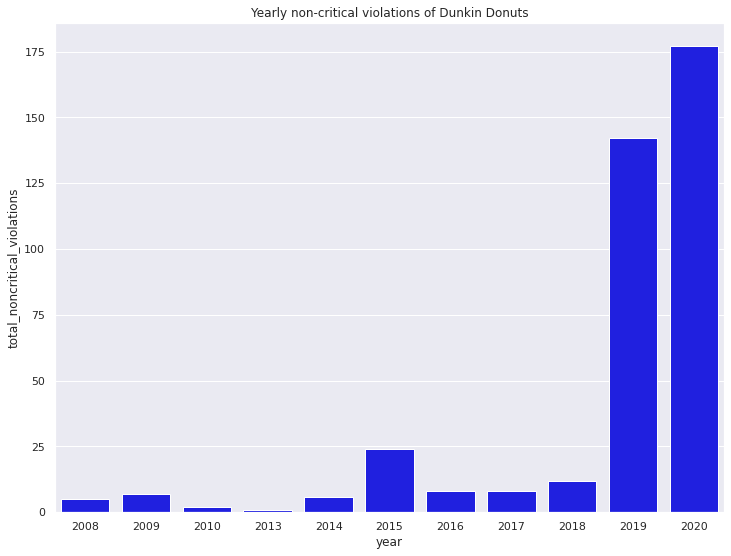

In [27]:
plt.title('Yearly non-critical violations of Dunkin Donuts')
g2=sns.barplot(
    data=donuts_noncritival_violations_by_year,
    x='year', y='total_noncritical_violations',
    color='blue'
)